## Project: Sign Language Digit Classification

**Group 4:**\
Darshik Alakkaparambil Somasundaran\
Hamna Ashraf

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2 
import os
import pandas as pd
import seaborn as sns


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Set the path to your data directory
train_dir = "../train_test/train"
test_dir = "../train_test/test"

# Set the input size
input_size = (64, 64)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest',
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 14375 images belonging to 10 classes.
Found 5375 images belonging to 10 classes.


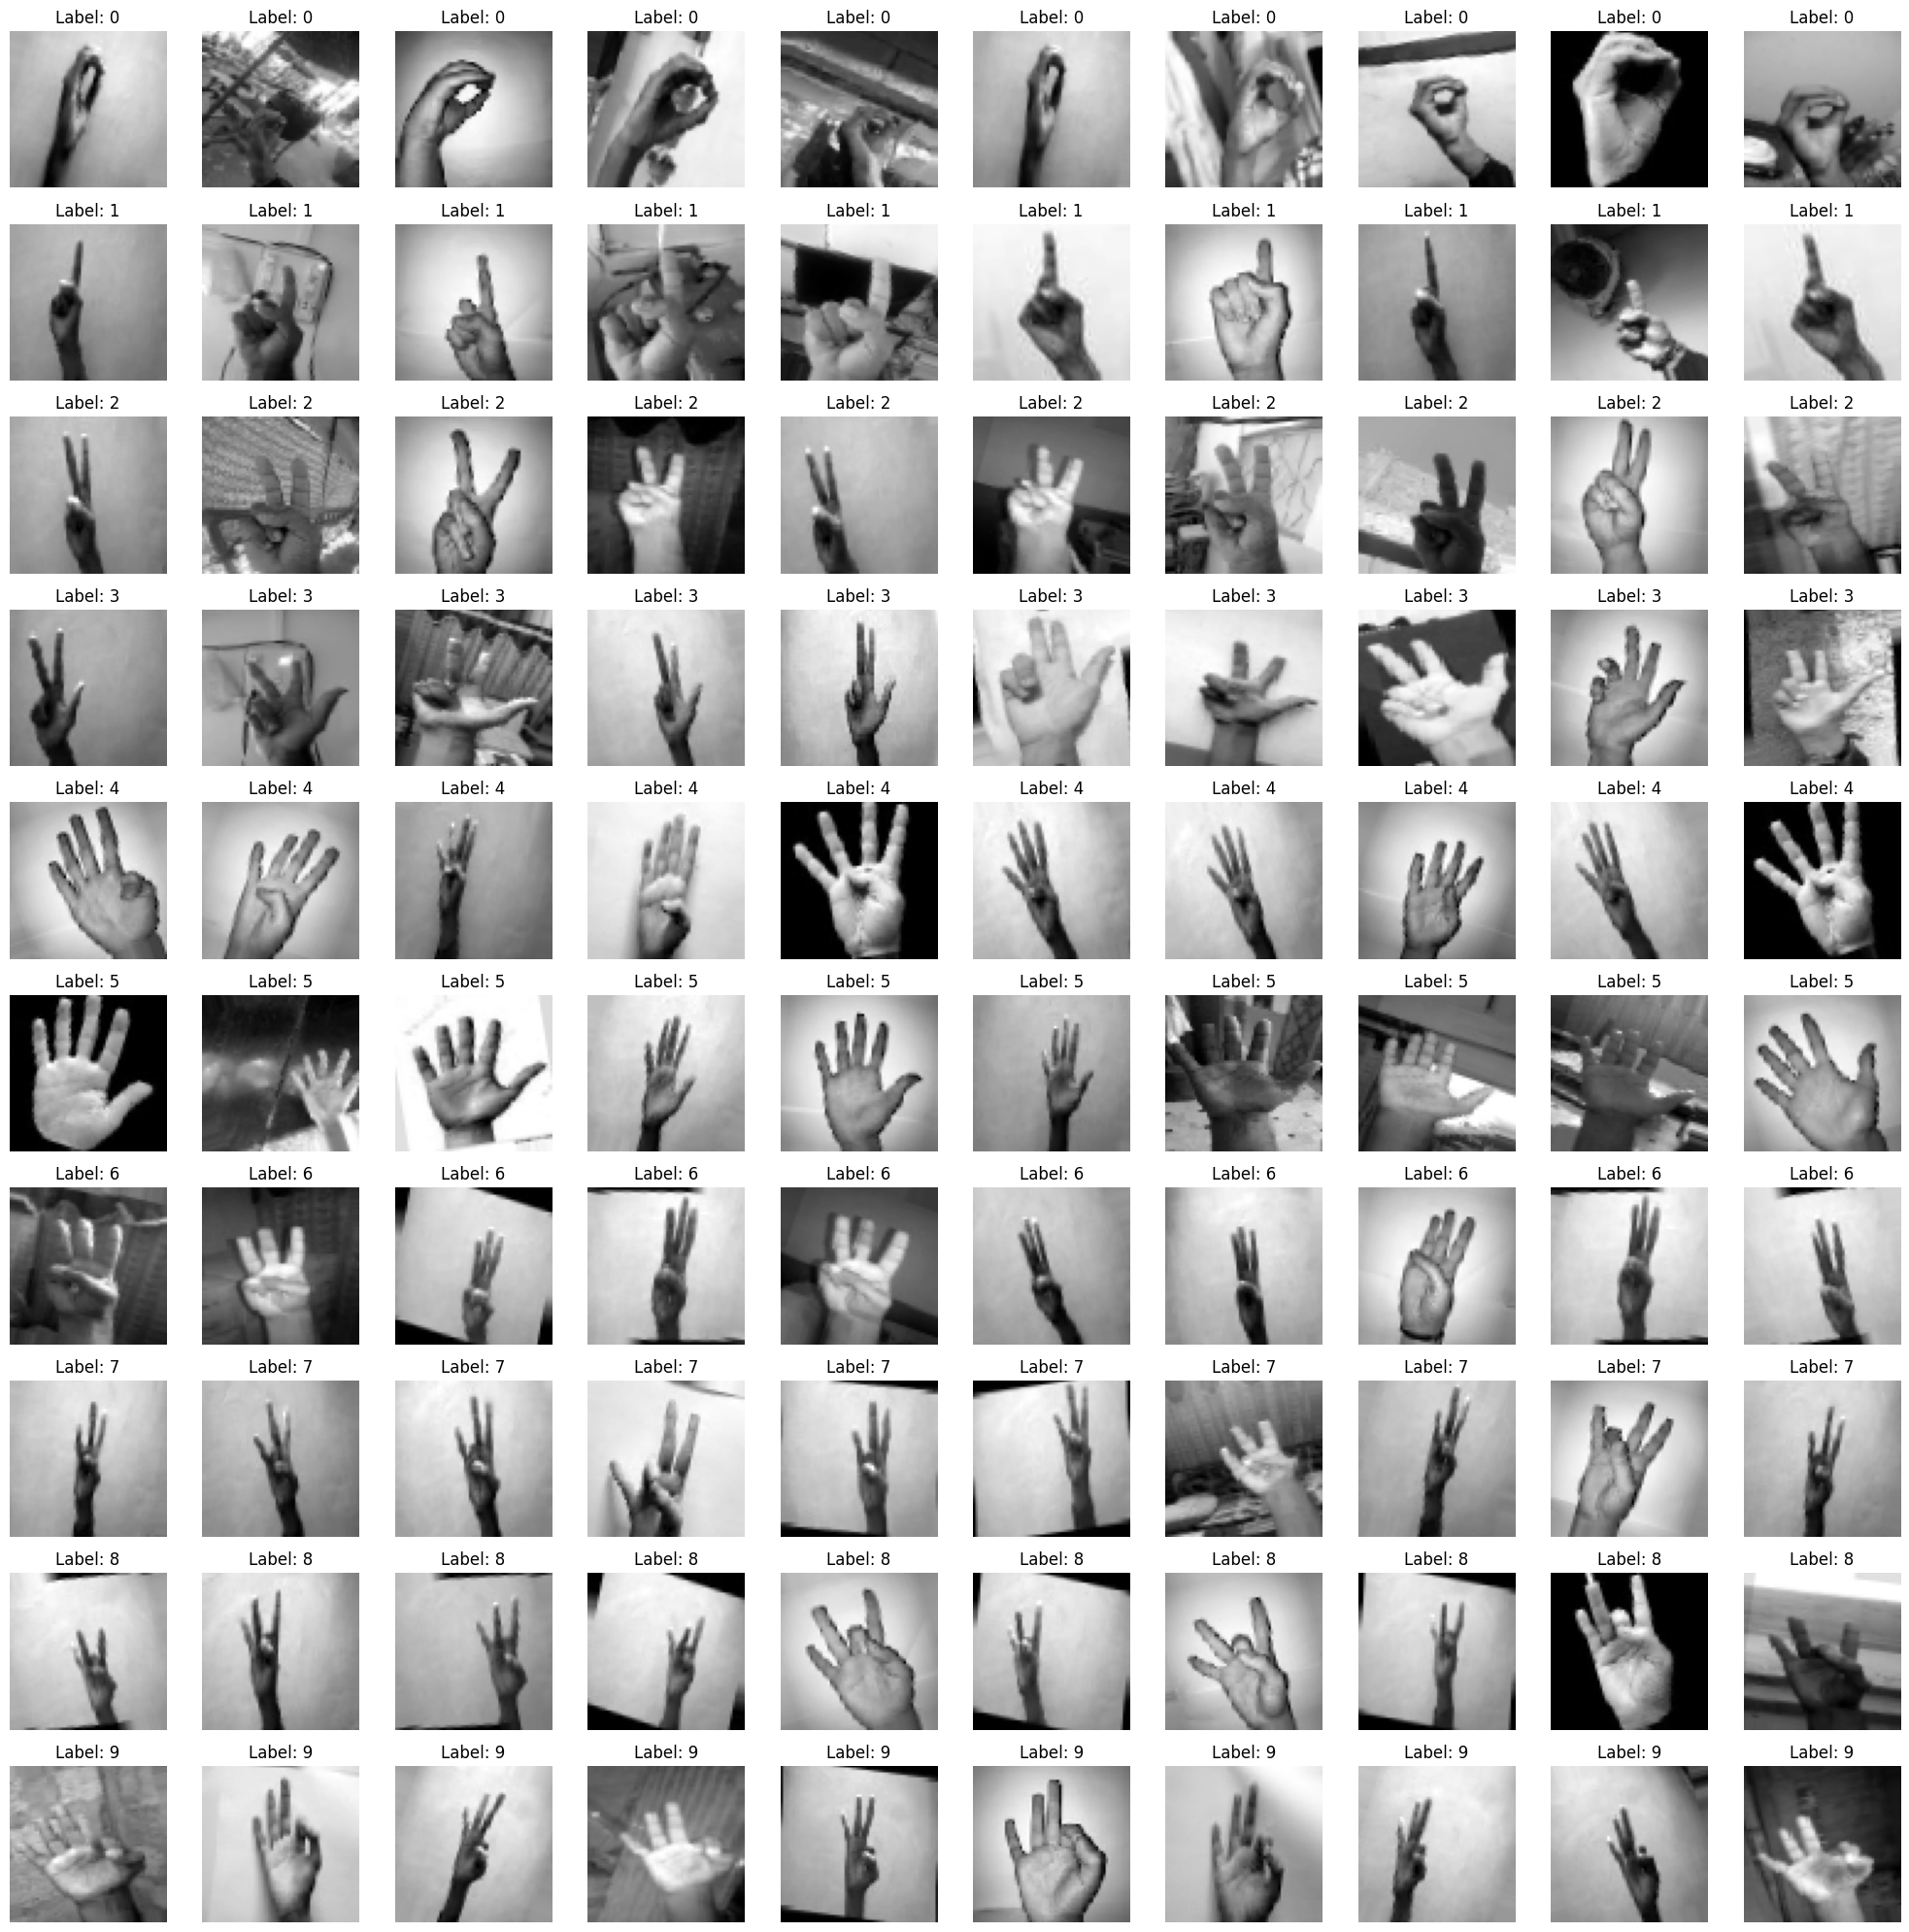

In [37]:
num_images = 10  # Number of images per class to display
class_images = {i: [] for i in range(10)}  # Adjust range if different number of classes

# Iterate through batches to collect images
for _ in range(100):  
    images, labels = next(train_generator)
    class_indices = np.argmax(labels, axis=1)
    
    for img, cls_idx in zip(images, class_indices):
        if len(class_images[cls_idx]) < num_images:
            class_images[cls_idx].append(img)
        # Break the inner loop if all classes have enough images
        if all(len(imgs) >= num_images for imgs in class_images.values()):
            break
    # Break the outer loop if all classes have enough images
    if all(len(imgs) >= num_images for imgs in class_images.values()):
        break

# Set up the figure
fig, axes = plt.subplots(nrows=10, ncols=num_images, figsize=(20, 20))

# Plot each class images in its row
for class_idx, imgs in class_images.items():
    for i, img in enumerate(imgs):
        axes[class_idx, i].imshow(img.reshape(64, 64), cmap='gray')  # Reshape for grayscale
        axes[class_idx, i].set_title(f'Label: {class_idx}')
        axes[class_idx, i].axis('off')

plt.tight_layout()
plt.show()



In [26]:
print("Shape of images: ",images.shape)
#(batch_size, height, width, channels)

Shape of images:  (32, 64, 64, 1)


In [12]:
# Function to count files in each subdirectory
def count_files_in_subdirectories(directory):
    label_distribution = {}
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            file_count = len(os.listdir(label_path))
            label_distribution[label] = file_count
    return label_distribution

# Count files in the training directory
train_distribution = count_files_in_subdirectories(train_dir)
test_distribution = count_files_in_subdirectories(test_dir)

# Print out the distributions
print("Training distribution:", train_distribution)
print("Testing distribution:", test_distribution)

Training distribution: {'0': 1432, '1': 1434, '2': 1444, '3': 1427, '4': 1441, '5': 1432, '6': 1437, '7': 1443, '8': 1451, '9': 1434}
Testing distribution: {'0': 532, '1': 534, '2': 544, '3': 527, '4': 541, '5': 532, '6': 537, '7': 543, '8': 551, '9': 534}


In [14]:
# Create a list to hold the data
data = []

# Iterate over each label directory and collect file paths and labels
for label in sorted(os.listdir(train_dir)):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            # Append the file path and label to the data list
            data.append((file_path, label))

# Create the DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Convert label to numeric type if necessary
df['label'] = df['label'].astype(int)

In [15]:
df = df.sample(frac=1).reset_index(drop=True)


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14375 entries, 0 to 14374
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  14375 non-null  object
 1   label      14375 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 168.6+ KB
None


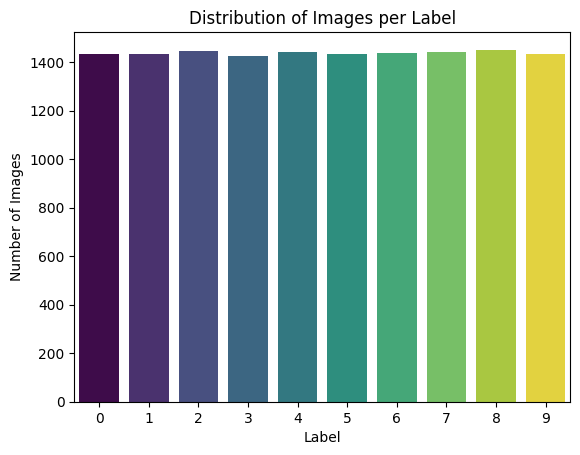

In [17]:
sns.countplot(x= 'label', hue = 'label', data= df, palette="viridis", order=sorted(df['label'].unique()), legend = False)
plt.title("Distribution of Images per Label")
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.show()

In [9]:
print(df['file_path'])


0          ../train_test/train\6\six_1066.jpg
1           ../train_test/train\6\six_664.jpg
2          ../train_test/train\0\zero_181.jpg
3           ../train_test/train\6\six_877.jpg
4         ../train_test/train\4\four_1416.jpg
                         ...                 
14370       ../train_test/train\1\one_518.jpg
14371       ../train_test/train\6\six_372.jpg
14372     ../train_test/train\5\five_1035.jpg
14373      ../train_test/train\9\nine_212.jpg
14374    ../train_test/train\7\seven_1489.jpg
Name: file_path, Length: 14375, dtype: object


100%|██████████| 14375/14375 [00:02<00:00, 5265.72it/s]


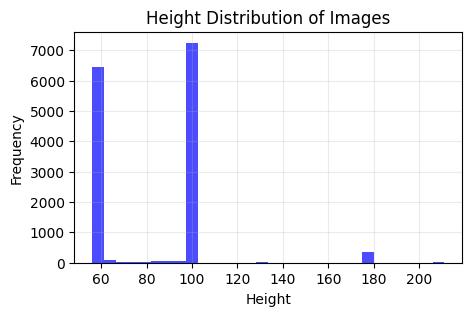

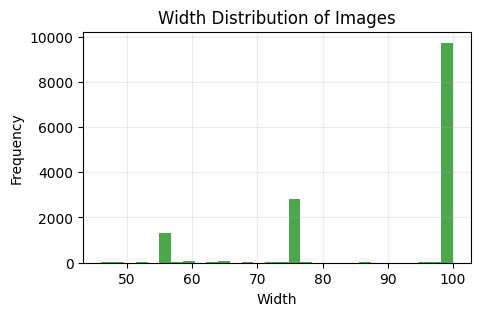

In [21]:
# Assuming df is your DataFrame and it has a 'file_path' column
# Initialize lists to store heights and widths
heights = []
widths = []

# Iterate through each image file path in the DataFrame
for file_path in tqdm(df['file_path']):
    image = cv2.imread(file_path)  # Read the image using OpenCV
    if image is not None:
        height, width, _ = image.shape  # Get the height and width of the image
        heights.append(height)
        widths.append(width)
    else:
        print(f"Warning: Unable to read image at {file_path}")

# Plot the distribution of heights
plt.figure(figsize=(5, 3))
plt.hist(heights, bins=30, color='blue', alpha=0.7)
plt.title('Height Distribution of Images')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()

# Plot the distribution of widths
plt.figure(figsize=(5, 3))
plt.hist(widths, bins=30, color='green', alpha=0.7)
plt.title('Width Distribution of Images')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()


In [20]:
stats = {str(i): {'means': [], 'std_devs': [], 'mins': [], 'maxes': []} for i in range(10)}

# Iterate through each image in the DataFrame
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_path = row['file_path']
    label = row['label']
    image = cv2.imread(image_path)

    # Check if the image is loaded properly
    if image is not None:
        # Convert the image to grayscale if it's not already
        if len(image.shape) > 2:
            grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            grayscale_image = image

        # Compute image statistics
        mean_pixel_value = np.mean(grayscale_image)
        std_dev_pixel_value = np.std(grayscale_image)
        min_pixel_value = np.min(grayscale_image)
        max_pixel_value = np.max(grayscale_image)

        # Append image statistics to the respective lists
        stats[str(label)]['means'].append(mean_pixel_value)
        stats[str(label)]['std_devs'].append(std_dev_pixel_value)
        stats[str(label)]['mins'].append(min_pixel_value)
        stats[str(label)]['maxes'].append(max_pixel_value)
    else:
        print(f"Warning: Unable to read image at {image_path}")

# Print overall statistics for each label
for label in stats:
    overall_mean = np.mean(stats[label]['means'])
    overall_std_dev = np.mean(stats[label]['std_devs'])
    overall_min = np.min(stats[label]['mins'])
    overall_max = np.max(stats[label]['maxes'])

    print(f"Label {label}:")
    print("  Overall Mean Pixel Value:", overall_mean)
    print("  Overall Standard Deviation of Pixel Values:", overall_std_dev)
    print("  Overall Minimum Pixel Value:", overall_min)
    print("  Overall Maximum Pixel Value:", overall_max)

100%|██████████| 14375/14375 [00:05<00:00, 2647.71it/s]

Label 0:
  Overall Mean Pixel Value: 123.28777121987113
  Overall Standard Deviation of Pixel Values: 41.553069610571875
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 1:
  Overall Mean Pixel Value: 123.43786028865617
  Overall Standard Deviation of Pixel Values: 41.79297934722956
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 2:
  Overall Mean Pixel Value: 125.83650023415471
  Overall Standard Deviation of Pixel Values: 42.38115342631701
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 3:
  Overall Mean Pixel Value: 125.11493343032232
  Overall Standard Deviation of Pixel Values: 40.33444787591876
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 4:
  Overall Mean Pixel Value: 123.78619496715214
  Overall Standard Deviation of Pixel Values: 41.51207344786768
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 5:
  Overall Mean Pixel Value: 114.9113470643597
  Ov

In [38]:
data = {
    'Label': [],
    'Mean Pixel Value': [],
    'Standard Deviation': []
}

for label, metrics in stats.items():
    data['Label'].extend([label] * len(metrics['means']))
    data['Mean Pixel Value'].extend(metrics['means'])
    data['Standard Deviation'].extend(metrics['std_devs'])

df_stats = pd.DataFrame(data)

In [43]:
print(stats.items())

dict_items([('0', {'means': [128.87803571428572, 127.9525, 71.67204081632653, 128.90767857142856, 119.6444, 125.15857142857143, 128.89017857142858, 67.9553, 128.03866666666667, 95.03239130434783, 127.72482142857143, 169.5667, 133.57089285714287, 128.71607142857144, 161.861, 86.062, 166.5331, 117.61826666666667, 127.64303571428572, 98.492, 120.9378313253012, 126.05233333333334, 133.2908, 137.78178571428572, 79.89946666666667, 129.81364705882353, 113.53106666666666, 113.1364, 113.89586666666666, 138.65666666666667, 158.535, 129.14373333333333, 110.99066666666667, 113.37346666666667, 109.81346666666667, 127.90517857142858, 109.3948, 117.83613333333334, 131.52035714285714, 132.55546666666666, 50.9409, 136.36613333333332, 111.40173333333334, 109.15573333333333, 49.51802469135802, 179.8014, 131.96625, 112.5464, 127.92267857142858, 124.2485, 152.181, 109.07345679012346, 132.32375, 46.5884, 80.42071428571428, 135.19035714285715, 125.27767857142857, 127.96285714285715, 100.36302325581396, 125.5

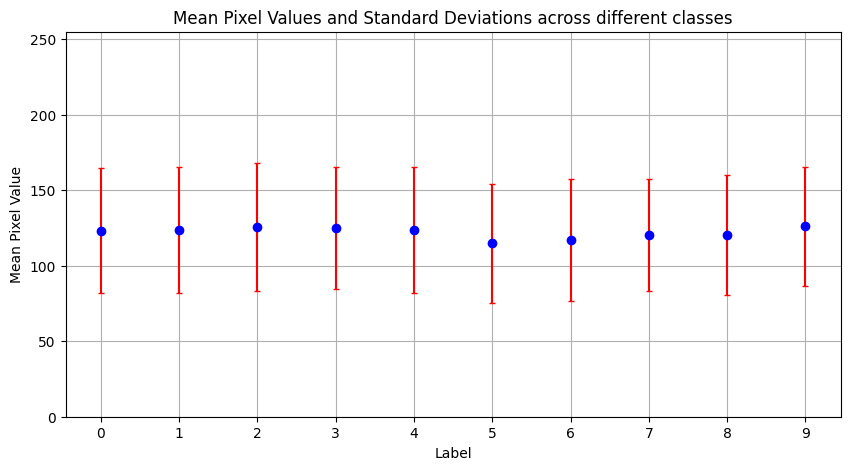

In [61]:

grouped_stats = df_stats.groupby('Label').agg({
    'Mean Pixel Value': 'mean',
    'Standard Deviation': 'mean'
}).reset_index()

labels = grouped_stats['Label']
mean_pixel_values = grouped_stats['Mean Pixel Value']
standard_deviations = grouped_stats['Standard Deviation']

# Converting labels to a numeric format for plotting
numeric_labels = np.arange(len(labels))

plt.figure(figsize=(10, 5))
plt.errorbar(numeric_labels, mean_pixel_values, yerr=standard_deviations, fmt='o', color='blue', ecolor='red', capsize=2)
plt.xticks(numeric_labels, labels)  # Set text labels for the x-axis
plt.title('Mean Pixel Values and Standard Deviations across different classes')
plt.xlabel('Label')
plt.ylabel('Mean Pixel Value')
plt.ylim(0,255)
plt.grid(True)
plt.show()